# German wings review challenge

The notebook shows two use cases.
The data is found in a text file holding a set of reviews about the German wings airline (airline code ‘4U’).


- ## First use case:
The goal of this use case is to show that based on the customer review data how to predict the target variable 'Recommended' (1 means positive, 0 means negative).


- ## Second use case:
The goal of the second use case is to find topics in the reviews.


The notebook covers the following topics:

- #### Data loading
    - loading the customer review data from txt to dataframe

- #### EDA
    - plotting distribution of the variables
    - plotting histograms
    - showing relationship between target variables to other variables
    - text analysis
        - plotting word frequencies
        - topic modeling with LDA
    
- #### Feature engineering
    - tfidf
    - count features
    - dimensionality reduction using truncated SVD
    - word embedding
        - glove
    
- #### Evaluation
    - logloss
    - roc curve
    - precision recall curve

- #### Machine learning models
    - logistic regression
    - navie bayes
    - gradient boost machine
        - xgboost
    - deep learning
        - lstm
        - gru
        - bidirectional lstm

- #### Error analysis


In [1]:
import collections
from collections import Counter

import sys, os, re, csv, codecs, math, logging, base64

from datetime import datetime

import statsmodels.formula.api as smf

import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype

import numpy as np
from numpy import inf

from scipy import stats, interp
from scipy.stats import skew, norm
from scipy.stats import randint as sp_randint
from scipy.misc import imread

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

import sklearn
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import Normalizer, StandardScaler, RobustScaler, label_binarize
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_absolute_error, mean_squared_error, confusion_matrix
from sklearn.metrics import classification_report, precision_recall_curve, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, average_precision_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation
from sklearn.utils.fixes import signature
 

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

import lightgbm as lgb

from hyperopt import hp, tpe, STATUS_OK, Trials
from hyperopt.fmin import fmin

from tqdm import tqdm

import keras
from keras.utils import np_utils
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model, Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence, text
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.callbacks import EarlyStopping

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')

#stop_words = nltk.download('stopwords')
stop_words = stopwords.words('english')

from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.filterwarnings("ignore")
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

#from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8")) #check the files available in the directory

np.random.seed(42)

/Users/kai/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning:

Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.

Using TensorFlow backend.
[nltk_data] Downloading package punkt to /Users/kai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/kai/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Load Data

In [2]:
# TODO: Refactor this function
def get_df_review(filename='4U_Reviews.txt', encoding = "ISO-8859-1"):
    """
    Load data in the txt file into a pandas dataframe.
    
    - Loop the text lines of the file.
    - For each text line
        - If the text line is not an empty line, then add the text line to the list.
        - Else I process the date in the list and save the processed data into the dictionary. After that, I clean the list.
    - At the end of the loop, I convert the dictionary into a pandas dataframe.
    """

    #map the content to dictionary
    dict_review = {'Title':[], 
                   'User Name':[], 
                   'Country':[], 
                   'Date':[],
                   'Rating':[], 
                   'Review':[], 
                   'Type Of Traveller':[], 
                   'Cabin Flown':[], 
                   'Route':[], 
                   'Date Flown':[], 
                   'Seat Comfort':[], 
                   'Cabin Staff Service':[], 
                   'Ground Service':[], 
                   'Value For Money':[], 
                   'Recommended':[]
                  }

    other_info_names = ['Type Of Traveller', 
                        'Cabin Flown', 
                        'Route', 
                        'Date Flown', 
                        'Seat Comfort', 
                        'Cabin Staff Service', 
                        'Ground Service', 
                        'Value For Money', 
                        'Recommended'
                       ]
    
    f = open(filename, "r", encoding = encoding)
    
    # The list is used to save temporal review data. 
    review_info_list = [] 
    for line in f:
        if line == '\n':
            #print("-----")
            #print(review_info_list)

            # get Title, User Name, Country, Date, Rating, Review
            for i, line in enumerate(review_info_list):
                # get title
                if i == 0:
                    #print('title: {}'.format(line))
                    dict_review['Title'].append(line)
                # get user name, country, date
                elif i == 1:
                    user_name = ''
                    country_name = ''
                    date_str = ''
                    
                    pos_start = line.find('(')
                    pos_end = line.find(')')
                    if pos_start != -1:
                        user_name = line[0:pos_start].strip()
                        country_name = line[pos_start+1:pos_end].strip()
                        date_str = line[pos_end+1:].strip()
                    else:
                        str_list = line.split()
                        if len(str_list) == 5:
                            user_name = str_list[0] + ' ' + str_list[1]
                            country_name = ''
                            date_str = str_list[-3].strip() + ' ' + str_list[-2].strip() + ' ' + str_list[-1].strip()
                        
                    #print('user name: {}'.format(user_name))
                    #print('country name: {}'.format(country_name))
                    #print('date: {}'.format(date_str))
                    dict_review['User Name'].append(user_name)
                    dict_review['Country'].append(country_name)
                    dict_review['Date'].append(date_str)
                # get rating
                elif i == 2:
                    if line.strip() == 'na':
                        rating = np.nan
                    else:
                        rating = int(line.strip())
                    #print('rating: {}'.format(rating))
                    dict_review['Rating'].append(rating)
                # get review
                elif i == 3:
                    #print('review')
                    #print(line.strip())
                    dict_review['Review'].append(line.strip())
            
            # get other information     
            for info_name in other_info_names:
                review_info = ''
                for i, line in enumerate(review_info_list):
                    pos = line.find(info_name)
                    if pos != -1:
                        review_info = line[len(info_name)+1:].strip()
                        break
                dict_review[info_name].append(review_info)

            review_info_list = [] 
        else:
            line = line.replace('\"', '')
            #print(line)
            review_info_list.append(line)

    df_review = pd.DataFrame(dict_review)
    
    # get route to and route from   
    def f_from(x):
        if x:
            return x.split()[0]
        return ''
    def f_to(x):
        if x:
            return x.split()[2]
        return ''
    df_review['Route From'] = df_review['Route'].apply(f_from)
    df_review['Route To'] = df_review['Route'].apply(f_to)
    
    return df_review    

In [3]:
df_review = get_df_review()

## 2. EDA and Data Processing

In [4]:
df_review.head()

,Title,User Name,Country,Date,Rating,Review,Type Of Traveller,Cabin Flown,Route,Date Flown,Seat Comfort,Cabin Staff Service,Ground Service,Value For Money,Recommended,Route From,Route To
0,they have been unresponsive\n,Brian McNamee,Canada,16th October 2015,2.000,We flew with Germanwings (or tried to) on Sept...,Couple Leisure,Economy,Stuttgart to Amsterdam,September 2015,12345,12345,12345,12345,no,Stuttgart,Amsterdam
1,I was refused some water\n,L Mouratidou,United Kingdom,4th October 2015,3.000,I am less than impressed with Germanwings serv...,Solo Leisure,Economy,Hamburg to London,September 2015,12345,12345,12345,12345,no,Hamburg,London
2,the service crew were friendly but nothing more\n,H Mutschler,Germany,21st September 2015,3.000,Flew from Palma de Mallorca to Cologne with Ge...,Couple Leisure,Economy,PMI to CGN,September 2015,12345,12345,12345,12345,no,PMI,CGN
3,"no problems or delays, very friendly staff\n",Oliver Numrich,Germany,20th September 2015,10.000,Good flight from Berlin-Tegel to London Heathr...,Business,,Berlin-Tegel to London Heathrow,August 2015,12345,12345,12345,12345,yes,Berlin-Tegel,London
4,I don't get why Germanwings is always late\n,Andreas Huettenhoelscher,Germany,14th September 2015,4.000,I don't get why Germanwings is always late and...,Business,Economy,CGN to LHR,September 2015,12345,12345,12345,12345,no,CGN,LHR


In [5]:
df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 17 columns):
Title                  127 non-null object
User Name              127 non-null object
Country                127 non-null object
Date                   127 non-null object
Rating                 114 non-null float64
Review                 127 non-null object
Type Of Traveller      127 non-null object
Cabin Flown            127 non-null object
Route                  127 non-null object
Date Flown             127 non-null object
Seat Comfort           127 non-null object
Cabin Staff Service    127 non-null object
Ground Service         127 non-null object
Value For Money        127 non-null object
Recommended            127 non-null object
Route From             127 non-null object
Route To               127 non-null object
dtypes: float64(1), object(16)
memory usage: 16.9+ KB


In [6]:
df_review.shape

(127, 17)

### 2.1 Analyse target variable 'Recommended' 

First use case: sentiment analysis
The goal is to predict the target variable 'Recommended' based on the reviews.

In [7]:
df_review['Recommended'].describe()

count     127
unique      2
top        no
freq       65
Name: Recommended, dtype: object

In [8]:
df_review['Recommended'].unique()

array(['no', 'yes'], dtype=object)

In [9]:
df_review['Recommended'].isnull().sum()

0

In [10]:
# Transfer string into integer
lbl_enc = preprocessing.LabelEncoder()
df_review['Recommended Label'] = lbl_enc.fit_transform(df_review['Recommended'].values)

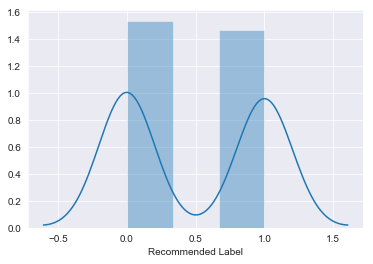

In [11]:
sns.distplot(df_review['Recommended Label'])

In [12]:
df_review[df_review['Recommended Label'] == 1].shape

(62, 18)

In [13]:
df_review[df_review['Recommended Label'] == 0].shape

(65, 18)

It shows the data between the two classes is balanced.

### 2.2 Analyse variable 'Rating' 

For the sentiment analysis use case, we can also consider the variable 'Rating' as the target variable.

In [14]:
df_review['Rating'].describe()

count   114.000
mean      5.588
std       2.874
min       1.000
25%       3.000
50%       5.000
75%       8.000
max      10.000
Name: Rating, dtype: float64

In [15]:
df_review['Rating'].unique()

array([ 2.,  3., 10.,  4.,  1.,  7.,  5.,  9.,  8., nan,  6.])

In [16]:
df_review['Rating'].isnull().sum()

13

In [17]:
df_review[df_review['Rating'].notnull()].shape

(114, 18)

In [18]:
df_review.shape

(127, 18)

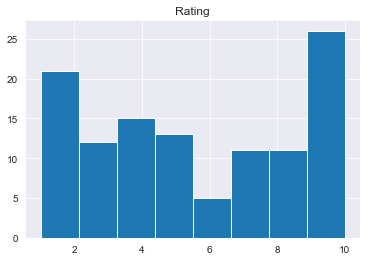

In [19]:
hist = df_review[df_review['Rating'].notnull()][['Rating']].hist(bins='auto')

It shows most of the customers give german wings the high ratings, i.e., from 9 to 10.

### 2.3 Analyse Missing Numerical Data

In [20]:
total = df_review.isnull().sum().sort_values(ascending=False)
percent = (df_review.isnull().sum()/df_review.count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
# missing_data.head(20)
missing_data

,Total,Percent
Rating,13,0.114
Recommended Label,0,0.000
Route To,0,0.000
User Name,0,0.000
Country,0,0.000
Date,0,0.000
Review,0,0.000
Type Of Traveller,0,0.000
Cabin Flown,0,0.000
Route,0,0.000


It shows that 10% of the customer does not rate the flights.

### 2.4 Show relationship between 'Recommended' and other variables

- #### Relationship with numerical variables

In [21]:
def show_relation_numerical(df, var, target):
    data = pd.concat([df[target], df[var]], axis=1)
    data.plot.scatter(x=var, y=target)

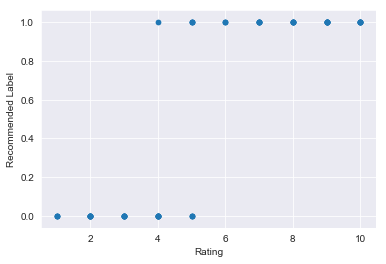

In [22]:
num_vars = ['Rating']
for num_var in num_vars:
    show_relation_numerical(df_review, num_var, 'Recommended Label')

It shows that 'Rating' is highly correlated with the target variable 'Recommended'.

- #### Relationship with categorical features

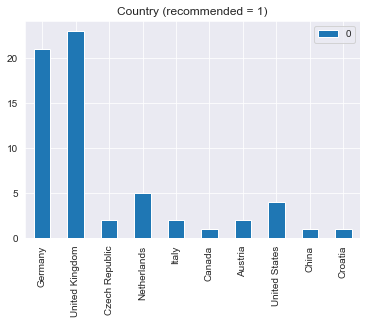

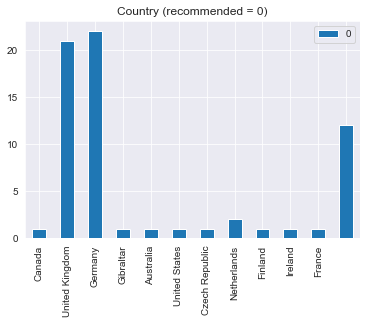

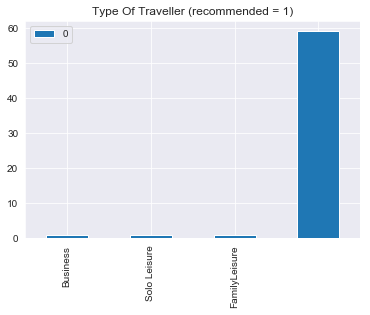

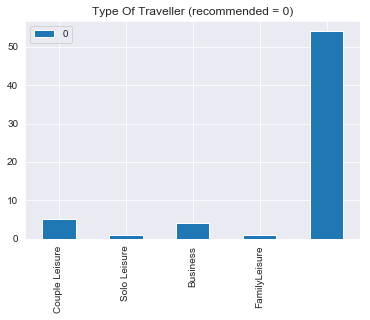

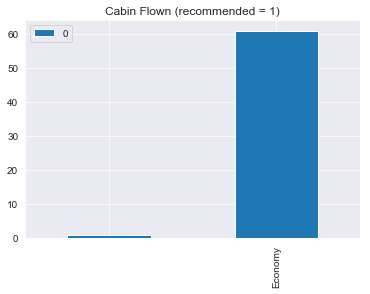

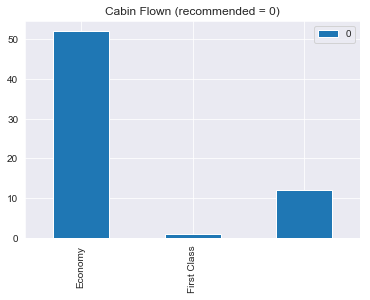

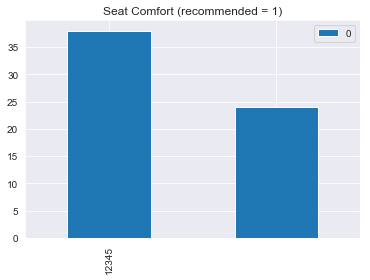

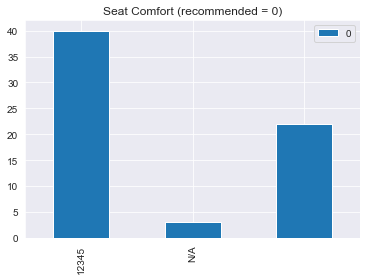

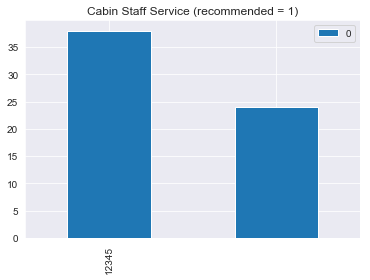

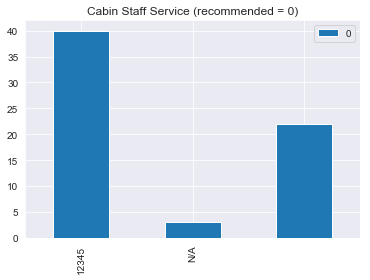

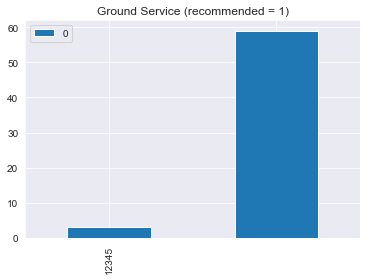

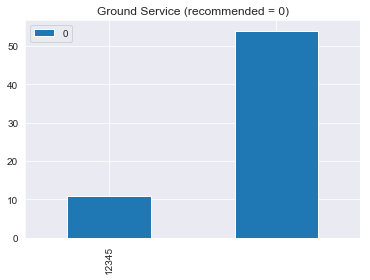

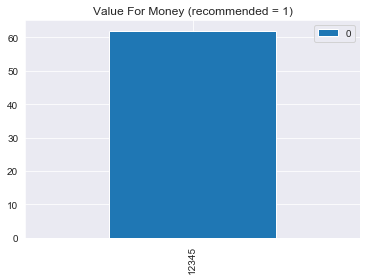

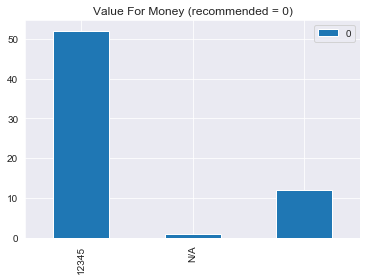

In [23]:
cat_vars = ['Country', 'Type Of Traveller', 'Cabin Flown', 'Seat Comfort', 'Cabin Staff Service', 'Ground Service', 'Value For Money']
                  
# https://stackoverflow.com/questions/28418988/how-to-make-a-histogram-from-a-list-of-strings-in-python
def plot_strings(a, title=''):
    letter_counts = Counter(a)
    df = pd.DataFrame.from_dict(letter_counts, orient='index')
    df.plot(kind='bar', title=title)
    
for cat_var in cat_vars:
    df = df_review[df_review['Recommended Label'] == 1][[cat_var]]
    plot_strings(df[cat_var].tolist(), title=cat_var+' (recommended = 1)')
    
    df = df_review[df_review['Recommended Label'] == 0][[cat_var]]
    plot_strings(df[cat_var].tolist(), title=cat_var+' (recommended = 0)')
    

It shows that there is a lot of missing data in the categorical features. The categorical features are not usefull to predict target variable 'Recommended'.

### 2.5 Text analysis

**Reference**

https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle

https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial

https://www.kaggle.com/theoviel/improve-your-score-with-some-text-preprocessing

- ### Title

In [24]:
df_review['Title'].unique()

array(['they have been unresponsive\n', 'I was refused some water\n',
       'the service crew were friendly but nothing more\n',
       'no problems or delays, very friendly staff\n',
       "I don't get why Germanwings is always late\n",
       'vowing never to book Germanwings again\n',
       'staff friendly - food terrible\n',
       'no explanations, no offers of help\n',
       'delay in Heathrow about 1:30 minutes\n',
       'Germanwings customer review\n'], dtype=object)

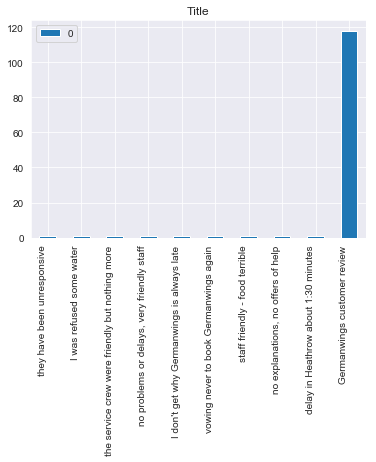

In [25]:
plot_strings(df_review['Title'], title='Title')

It shows that most of the reviews have the title 'Germanwings customer review'. Therefore, I will not use 'Title' as a feature to predict 'Recommended'

- ### Review

- Show top 50word frequencies of the reviews

In [26]:
df_review["Review"] = df_review["Review"].fillna("_na_").values

In [27]:
# The code is adapted from
# https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial
all_words = df_review["Review"].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the dataset'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

- Show top 50 word frequencies of positive reviews, i.e., recommended.

In [28]:
all_words = df_review[df_review['Recommended']=="yes"]["Review"].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the positive reviews'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

- Show top 50 word frequencies of negative reviews, i.e., not recommended.

In [29]:
all_words = df_review[df_review['Recommended']=="no"]["Review"].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the negative reviews'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [30]:
pos_review = df_review[df_review['Recommended']=="yes"]["Review"].values
neg_review = df_review[df_review['Recommended']=="no"]["Review"].values

- Using wordcloud to show the top 50 words of positive reviews and negative reviews.

(-0.5, 399.5, 199.5, -0.5)

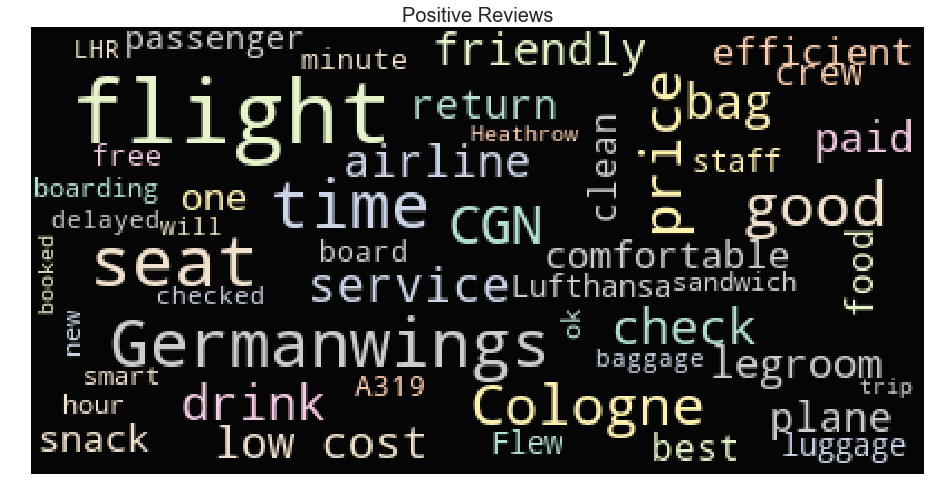

In [31]:
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", 
               max_words=50, 
               #mask=hcmask1, 
               stopwords=STOPWORDS, 
               max_font_size= 40
              )
wc.generate(" ".join(pos_review))

plt.title("Positive Reviews", fontsize=20)

# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)

plt.imshow(wc.recolor(colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

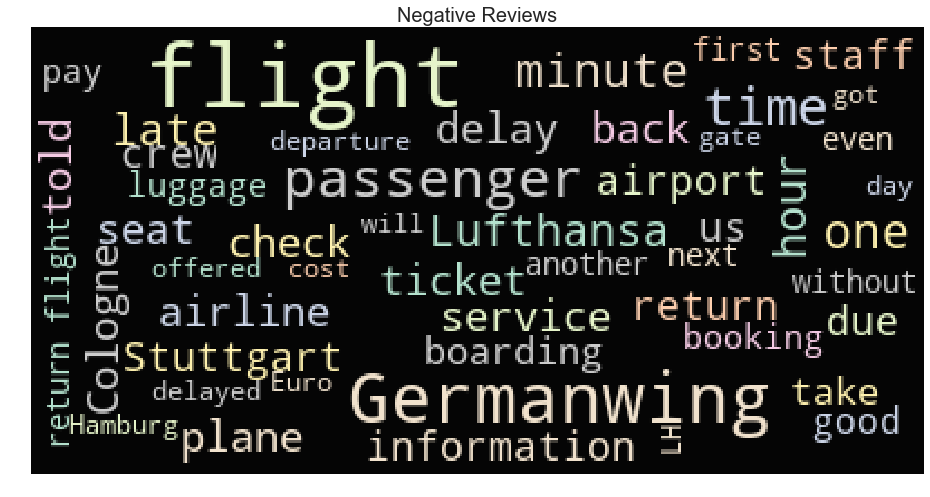

In [32]:
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", 
               max_words=50, 
               #mask=hcmask2, 
               stopwords=STOPWORDS, 
               max_font_size= 40
              )
wc.generate(" ".join(neg_review))

plt.title("Negative Reviews", fontsize=20)

# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)

plt.imshow(wc.recolor(colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

- ## 2.6 Topic Modeling 


One of the primary applications of natural language processing is to automatically extract what topics people are discussing from large volumes of text. Some examples of large text could be feeds from social media, customer reviews of hotels, movies, etc, user feedbacks, news stories, e-mails of customer complaints etc.

Knowing what people are talking about and understanding their problems and opinions is highly valuable to businesses, administrators, political campaigns. And it’s really hard to manually read through such large volumes and compile the topics.

Thus is required an automated algorithm that can read through the text documents and automatically output the topics discussed.



**Reference**

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial

- ### 2.6.1 Stemming and Lemmatization

The work at this stage attempts to reduce as many different variations of similar words into a single term ( different branches all reduced to single word stem). Therefore if we have "running", "runs" and "run", you would really want these three distinct words to collapse into just the word "run". (However of course you lose granularity of the past, present or future tense).


In [33]:
stemmer = nltk.stem.PorterStemmer()

In [34]:
print("The stemmed form of running is: {}".format(stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(stemmer.stem("run")))

The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run


We turn to another that we could use in lieu of stemming. 
This method is called lemmatization which aims to achieve the same effect as the former method. 
However unlike a stemmer, lemmatizing the dataset aims to reduce words based on an actual dictionary or vocabulary (the Lemma) and therefore will not chop off words into stemmed forms that do not carry any lexical meaning. 

Here we can utilize NLTK once again to initialize a lemmatizer (WordNet variant) and inspect how it collapses words as follows:

In [35]:
lemm = WordNetLemmatizer()
print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("leaves")))

The lemmatized form of leaves is: leaf


In [36]:
lemm = WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

In [37]:
def show_word_frequencies(text, num_words=50, title='Top 50 Word frequencies after Preprocessing'):
    tf_vectorizer = LemmaCountVectorizer(max_df=0.95, 
                                     min_df=2,
                                     stop_words='english',
                                     decode_error='ignore')
    tf = tf_vectorizer.fit_transform(text)

    feature_names = tf_vectorizer.get_feature_names()

    count_vec = np.asarray(tf.sum(axis=0)).ravel()

    zipped = list(zip(feature_names, count_vec))

    x, y = (list(x) for x in zip(*sorted(zipped, key=lambda x: x[1], reverse=True)))

    # Now I want to extract out on the top 15 and bottom 15 words
    Y = np.concatenate([y[0:15], y[-16:-1]])
    X = np.concatenate([x[0:15], x[-16:-1]])

    # Plotting the Plot.ly plot for the Top num_words word frequencies
    data = [go.Bar(x = x[0:num_words],
                   y = y[0:num_words],
                   marker= dict(colorscale='Jet',color = y[0:num_words]),
                   text='Word counts')]
    
    layout = go.Layout(title=title)

    fig = go.Figure(data=data, layout=layout)

    py.iplot(fig, filename='basic-bar')

    # Plotting the Plot.ly plot for the Top 50 word frequencies
    data = [go.Bar(x = x[-100:],
                   y = y[-100:],
                   marker= dict(colorscale='Portland',color = y[-100:]),
                   text='Word counts')]
    
    return tf, tf_vectorizer

In [38]:
text = list(df_review['Review'].values)
tf, tf_vectorizer = show_word_frequencies(text, title='Top 50 Word frequencies after Preprocessing')

In [39]:
pos_review = df_review[df_review['Recommended']=="yes"]["Review"].values
neg_review = df_review[df_review['Recommended']=="no"]["Review"].values

In [40]:
pos_text = list(pos_review)
show_word_frequencies(pos_text, title='Top 50 Word frequencies of positive reviews after Preprocessing')

(<62x381 sparse matrix of type '<class 'numpy.int64'>'
 	with 1860 stored elements in Compressed Sparse Row format>,
 LemmaCountVectorizer(analyzer='word', binary=False, decode_error='ignore',
            dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
            lowercase=True, max_df=0.95, max_features=None, min_df=2,
            ngram_range=(1, 1), preprocessor=None, stop_words='english',
            strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
            tokenizer=None, vocabulary=None))

In [41]:
neg_text = list(neg_review)
show_word_frequencies(neg_text, title='Top 50 Word frequencies of negative reviews after Preprocessing')

(<65x491 sparse matrix of type '<class 'numpy.int64'>'
 	with 2185 stored elements in Compressed Sparse Row format>,
 LemmaCountVectorizer(analyzer='word', binary=False, decode_error='ignore',
            dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
            lowercase=True, max_df=0.95, max_features=None, min_df=2,
            ngram_range=(1, 1), preprocessor=None, stop_words='english',
            strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
            tokenizer=None, vocabulary=None))

- ### 2.6.2 LDA

In natural language processing, latent Dirichlet allocation (LDA) is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. For example, if observations are words collected into documents, it posits that each document is a mixture of a small number of topics and that each word's presence is attributable to one of the document's topics. LDA is an example of a topic model.


The latent Dirichlet allocation (LDA) algorithm first models documents via a mixture model of topics. 
From these topics, words are then assigned weights based on the probability distribution of these topics. 
It is this probabilistic assignment over words that allow a user of LDA to say how likely a particular word falls into a topic. 
Subsequently from the collection of words assigned to a particular topic, are we thus able to gain an insight as to what that topic may actually represent from a lexical point of view.


**Reference**

https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

https://scikit-learn.org/stable/modules/decomposition.html#latentdirichletallocation

https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial

https://www.youtube.com/watch?v=3mHy4OSyRf0


In [42]:
lda = LatentDirichletAllocation(n_components=10, max_iter=5,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0)

In [43]:
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [44]:
# Define helper function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

In [45]:
n_top_words = 50
print("\nTopics in LDA model: ")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model: 

Topic #0:fortunately main fare level probably collect 23kg buy online book organised clear ve plus choice bad view alliance 100 applied tell 05 gave twice emergency enter available march offer proper rude swift drink voucher went process week close 25 ended flown 2013 modern procedure 29 newspaper queue toilet recently funny

Topic #1:staff flight ham hour ticket germanwings airline route economy making based time checked arrived stuttgart just delay efficient able air passenger bus really delayed second advised extra 29th 900 expect wasn planned dusseldorf operator paid comfortable cologne error card member join cost included price modern home ground swiss vie disappointed

Topic #2:flight check seat time good cologne staff germanwings airline crew low cost minute friendly return cabin hour quite free ticket late ok passenger cheap lufthansa onboard delayed price bag want board plane extra booking short pay departure drink reasonably nice lh luggage efficient c

In [46]:
first_topic = lda.components_[0]
second_topic = lda.components_[1]
third_topic = lda.components_[2]
fourth_topic = lda.components_[3]

In [47]:
first_topic_words = [tf_feature_names[i] for i in first_topic.argsort()[:-50 - 1 :-1]]
second_topic_words = [tf_feature_names[i] for i in second_topic.argsort()[:-50 - 1 :-1]]
third_topic_words = [tf_feature_names[i] for i in third_topic.argsort()[:-50 - 1 :-1]]
fourth_topic_words = [tf_feature_names[i] for i in fourth_topic.argsort()[:-50 - 1 :-1]]

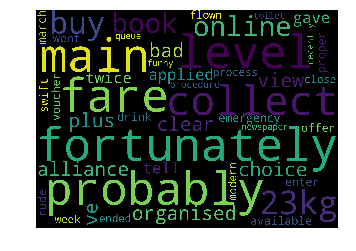

In [48]:
firstcloud = WordCloud(stopwords=STOPWORDS,
                       background_color='black',
                       width=2500,
                       height=1800
                      ).generate(" ".join(first_topic_words))
plt.imshow(firstcloud)
plt.axis('off')
plt.show()

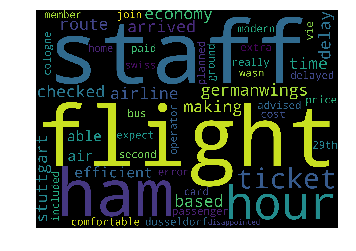

In [49]:
secondcloud = WordCloud(stopwords=STOPWORDS,
                       background_color='black',
                       width=2500,
                       height=1800
                      ).generate(" ".join(second_topic_words))
plt.imshow(secondcloud)
plt.axis('off')
plt.show()

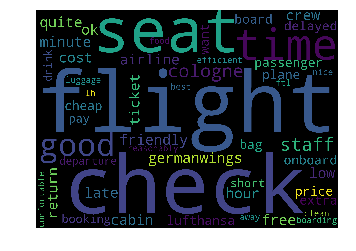

In [50]:
thirdcloud = WordCloud(stopwords=STOPWORDS,
                       background_color='black',
                       width=2500,
                       height=1800
                      ).generate(" ".join(third_topic_words))
plt.imshow(thirdcloud)
plt.axis('off')
plt.show()

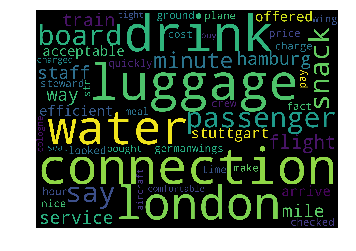

In [51]:
fourthcloud = WordCloud(stopwords=STOPWORDS,
                       background_color='black',
                       width=2500,
                       height=1800
                      ).generate(" ".join(fourth_topic_words))
plt.imshow(fourthcloud)
plt.axis('off')
plt.show()

#### TODO

visualizing the topics 

https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

## 3. Modeling

The sentiment analysis problem is formulated into a binary classification problem, i.e., classify the text data (review) into recommended and non-recommended.

- #### Define evaluation metric

Kaggle has specified multi-class log-loss as evaluation metric.

The implementation is taken from: 

https://github.com/dnouri/nolearn/blob/master/nolearn/lasagne/util.py)

https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle

In [52]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

- #### Plot precision recall curve

https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py

In [53]:
def plot_pr_curve(y_test, y_score, model_name, features):
    # calculate average precision score
    average_precision = average_precision_score(y_test, y_score)
    
    #print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    
    # calculate precision-recall AUC
    auc = sklearn.metrics.auc(recall, precision)
    
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}, AUC={1:0.2f}, model={2}, features={3}'.format(average_precision, 
                                                                                                           auc,
                                                                                                           model_name,
                                                                                                           features
                                                                                                            ))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    return auc, average_precision

- #### Plot AUC curve

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

https://qiita.com/bmj0114/items/460424c110a8ce22d945

In [54]:
def plot_auc_curve(y_test, y_score, model_name, features):
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    score = roc_auc_score(y_test, y_score)
    roc_auc = sklearn.metrics.auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: ROC_AUC_Score={0:0.2f}, model={1}, features={2}'.format(score,roc_auc,model_name,features))
    plt.legend(loc="lower right")
    plt.show()
    
    return score

- #### Prepare data sets
    - X: features, 'Review', text data
    - y: target, 'Recommended Label', 0 or 1

In [55]:
y = df_review['Recommended Label']

In [56]:
xtrain, xvalid, ytrain, yvalid = train_test_split(df_review['Review'].values, 
                                                  y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.2, 
                                                  shuffle=True)

In [57]:
print (xtrain.shape)
print (xvalid.shape)

(101,)
(26,)


- #### TF-IDF

Text data requires special preparation before you can start using it for predictive modeling.

The text must be parsed to remove words, called tokenization. Then the words need to be encoded as integers or floating point values for use as input to a machine learning algorithm, called feature extraction (or vectorization).

Tf means term-frequency while tf–idf means term-frequency times inverse document-frequency. 

Word counts are a good starting point, but are very basic.

One issue with simple counts is that some words like “the” will appear many times and their large counts will not be very meaningful in the encoded vectors.

An alternative is to calculate word frequencies, and by far the most popular method is called TF-IDF. This is an acronym than stands for “Term Frequency – Inverse Document” Frequency which are the components of the resulting scores assigned to each word.

- **Term Frequency**: This summarizes how often a given word appears within a document.

- **Inverse Document Frequency**: This downscales words that appear a lot across documents.
Without going into the math, TF-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across documents.


For the details of tf-idf, we refer to

https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/



In [58]:
tfv = TfidfVectorizer(min_df=3,  
                      max_features=None, 
                      strip_accents='unicode', 
                      analyzer='word',
                      token_pattern=r'\w{1,}',
                      ngram_range=(1, 3), 
                      use_idf=1,
                      smooth_idf=1,
                      sublinear_tf=1,
                      stop_words = 'english',
                     )

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain) + list(xvalid))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)

In [59]:
# Fitting a simple Logistic Regression on TFIDF
clf = LogisticRegression()
clf.fit(xtrain_tfv, ytrain)

predictions = clf.predict_proba(xvalid_tfv)
ypred = clf.predict(xvalid_tfv)

- #### Logloss

For a binary classification like our example, the typical loss function is the binary cross-entropy / log loss.

$$H_p(q) = - \frac{1}{N} \sum_{i=1}^{N} y_i \times log(p(y_i)) + (1-y_i) \times log(1-p(y_i))$$

Neural networks are trained using stochastic gradient descent and require that you choose a loss function when designing and configuring your model.

Given input, the model is trying to make predictions that match the data distribution of the target variable. Under maximum likelihood, a loss function estimates how closely the distribution of predictions made by a model matches the distribution of target variables in the training data.

**Cross-Entropy Loss** (or Log Loss)

Cross-entropy loss is often simply referred to as “cross-entropy,” “logarithmic loss,” “logistic loss,” or “log loss” for short.

Each predicted probability is compared to the actual class output value (0 or 1) and a score is calculated that penalizes the probability based on the distance from the expected value. The penalty is logarithmic, offering a small score for small differences (0.1 or 0.2) and enormous score for a large difference (0.9 or 1.0).

Cross-entropy loss is minimized, where smaller values represent a better model than larger values. A model that predicts perfect probabilities has a cross entropy or log loss of 0.0.

Cross-entropy for a binary or two class prediction problem is actually calculated as the average cross entropy across all examples.

Given a framework of maximum likelihood, we know that we want to use a cross-entropy or mean squared error loss function under stochastic gradient descent.

Nevertheless, we may or may not want to report the performance of the model using the loss function.

For example, logarithmic loss is challenging to interpret, especially for non-machine learning practitioner stakeholders. The same can be said for the mean squared error. Instead, it may be more important to report the accuracy and root mean squared error for models used for classification and regression respectively.

It may also be desirable to choose models based on these metrics instead of loss. This is an important consideration, as the model with the minimum loss may not be the model with best metric that is important to project stakeholders.

A good division to consider is to use the loss to evaluate and diagnose how well the model is learning. This includes all of the considerations of the optimization process, such as overfitting, underfitting, and convergence. An alternate metric can then be chosen that has meaning to the project stakeholders to both evaluate model performance and perform model selection.

The same metric can be used for both concerns but it is more likely that the concerns of the optimization process will differ from the goals of the project and different scores will be required. Nevertheless, it is often the case that improving the loss improves or, at worst, has no effect on the metric of interest.


**Reference**

https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

https://medium.com/30-days-of-machine-learning/day-5-entropy-relative-entropy-and-cross-entropy-8369d67cc180

https://machinelearningmastery.com/loss-and-loss-functions-for-training-deep-learning-neural-networks/

https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/

In [60]:
print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.611 


- #### Precision Recall curve

    - Precision-Recall curves summarize the trade-off between the **true positive rate** and the **positive predictive value** for a predictive model using different probability thresholds.
    - Precision-Recall curves are appropriate for imbalanced datasets, whereas ROC curves are appropriate when the observations are balanced between each class.

**Precision** is a ratio of the number of true positives divided by the sum of the true positives and false positives. It describes how good a model is at predicting the positive class. Precision is referred to as the positive predictive value.

$${Precision} = \frac{True Positives} {(True Positives + False Positives)}$$

**Recall** is calculated as the ratio of the number of true positives divided by the sum of the true positives and the false negatives. Recall is the same as sensitivity.

$${Recall} = \frac{True Positives} {(True Positives + False Negatives)}$$

Reviewing both precision and recall is useful in cases where there is an imbalance in the observations between the two classes. Specifically, there are many examples of no event (class 0) and only a few examples of an event (class 1).

The reason for this is that typically the large number of class 0 examples means we are less interested in the skill of the model at predicting class 0 correctly, e.g. high true negatives.

There are also composite scores that attempt to summarize the precision and recall; three examples include:

- **F score** or **F1 score**: that calculates the harmonic mean of the precision and recall (harmonic mean because the precision and recall are ratios).

- **Average precision**: that summarizes the weighted increase in precision with each change in recall for the thresholds in the precision-recall curve.

- **Area Under Curve**: like the AUC, summarizes the integral or an approximation of the area under the precision-recall curve.

In terms of model selection, F1 summarizes model skill for a specific probability threshold, whereas average precision and area under curve summarize the skill of a model across thresholds, like ROC AUC.

This makes precision-recall and a plot of precision vs. recall and summary measures useful tools for binary classification problems that have an imbalance in the observations for each class.

The above explaination of Precision and Recall is taken from

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/



pr-auc: 0.8626614134324302
average precision: 0.8677735134331941


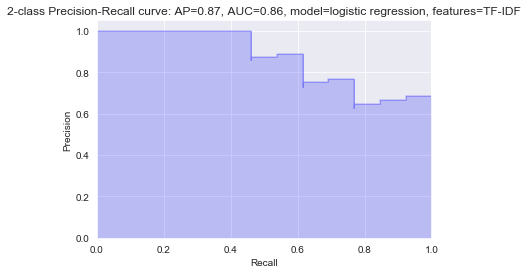

In [61]:
pr_auc, average_precision = plot_pr_curve(yvalid, predictions[:, 1], model_name='logistic regression', features='TF-IDF')

print('pr-auc: {}'.format(pr_auc))
print('average precision: {}'.format(average_precision))

In [62]:
print(classification_report(yvalid.values, ypred))

              precision    recall  f1-score   support

           0       0.75      0.69      0.72        13
           1       0.71      0.77      0.74        13

   micro avg       0.73      0.73      0.73        26
   macro avg       0.73      0.73      0.73        26
weighted avg       0.73      0.73      0.73        26



- #### ROC curve

    - ROC Curves summarize the trade-off between the **true positive rate** and **false positive rate** for a predictive model using different probability thresholds.
    
    - ROC curves are appropriate when the observations are balanced between each class, whereas precision-recall curves are appropriate for imbalanced datasets.
    
$${True Positive Rate} = \frac{True Positives} {(True Positives + False Negatives)}$$
The true positive rate is also referred to as sensitivity.

$${False Positive Rate} = \frac{False Positives} {(False Positives + True Negatives)}$$

The false positive rate is also referred to as the inverted specificity where specificity is the total number of true negatives divided by the sum of the number of true negatives and false positives.

$${Specificity} = \frac{True Negatives} {(True Negatives + False Positives)}$$

$${False Positive Rate} = 1 - {Specificity}$$

The ROC curve is a useful tool for a few reasons:

- The curves of different models can be compared directly in general or for different thresholds.
- The area under the curve (AUC) can be used as a summary of the model skill.


https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

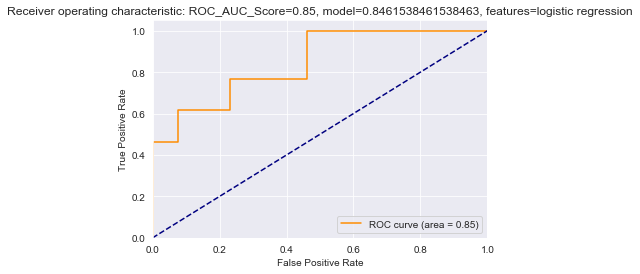

roc auc score: 0.8461538461538463


In [63]:
auc_score = plot_auc_curve(yvalid, predictions[:, 1], model_name='logistic regression',  features='TF-IDF')

print('roc auc score: {}'.format(auc_score))

- ### Put all the evaluation metrics in one function

In [64]:
def show_performance(yvalid, predictions, ypred, model_name, features):
    print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))
    
    pr_auc, average_precision = plot_pr_curve(yvalid, predictions[:, 1], model_name=model_name, features=features)

    print('pr-auc: {}'.format(pr_auc))
    print('average precision: {}'.format(average_precision))
    
    print(classification_report(yvalid.values, ypred))

    auc_score = plot_auc_curve(yvalid, predictions[:, 1], model_name=model_name,  features=features)

    print('roc auc score: {}'.format(auc_score))

logloss: 0.611 
pr-auc: 0.8626614134324302
average precision: 0.8677735134331941
              precision    recall  f1-score   support

           0       0.75      0.69      0.72        13
           1       0.71      0.77      0.74        13

   micro avg       0.73      0.73      0.73        26
   macro avg       0.73      0.73      0.73        26
weighted avg       0.73      0.73      0.73        26



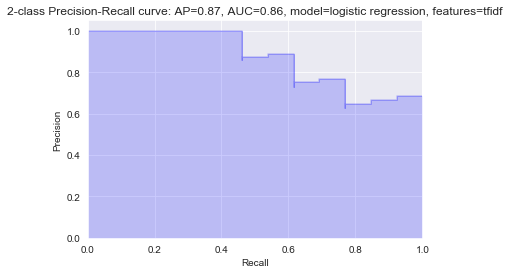

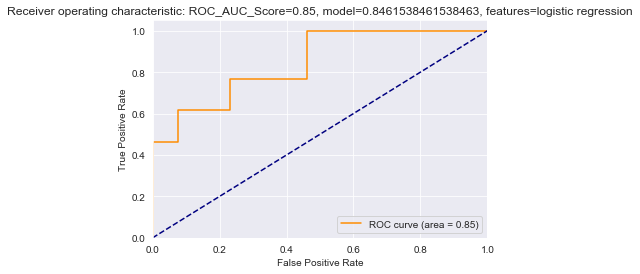

roc auc score: 0.8461538461538463


In [65]:
show_performance(yvalid, predictions, ypred, 'logistic regression', 'tfidf')

- Error analysis

In [66]:
def get_error_pred(yvalid, ypred):
    """
    Generate a dataframe contains the missclassified data
    """
    index_error = yvalid != ypred
    x_error = xvalid[index_error]
    ytrue_error = yvalid[index_error].values
    ypred_error = ypred[index_error]
    
    df_error = pd.DataFrame({'x':x_error, 'y_true':ytrue_error, 'y_pred':ypred_error})
    
    return df_error

In [67]:
def show_error_classification(yvalid, ypred):
    """
    Print the misclassified reviews
    """
    df_error = get_error_pred(yvalid, ypred)
    for index, row in df_error.iterrows():
        print('index: {}'.format(index))
        print(row['x'])
        print('true label: {}'.format(row['y_true']))
        print('\n')

In [68]:
show_error_classification(yvalid, ypred)

index: 0
Booked Lufthansa flight Cologne-Berlin on 28 Jan. On 2 Jan I got the information that the flight was operated by Germanwings a German low-cost carrier. So was the flight. Low cost: 1 hrs delayed for my beer I had to pay in Euros - cash. Lounge use was denied as the flight was operated under 4U code. No service for a high Lufthansa price. Not recommended very disappointed.
true label: 0


index: 1
First time I have used Germanwings for connecting flights (via Hamburg). The APP does not work properly. They are unable to issue both boarding cards on check in causing unnecessary inconvenience. Their Live Twitter response averages 24 hours to reply. Cabin crew spend most time behind front galley curtains. Also fail to do proper cabin secure checks prior to landing. Seats new ultra thin models OK for short flights. Seat pitch OK on the extra space seats. Smart fare snack boring and repetitive. They have taken over a lot of Lufthansa routes and to be honest they are not really geared

- #### Summary


Review 2 is not clear for me it was positive or negative.

Reviews 4, 5 has some pros and cons.

Reviews 3, 6 could be neutral.

- #### Count Features

Convert a collection of text documents to a matrix of token counts. For more details, we refer to 

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html



In [69]:
ctv = CountVectorizer(analyzer='word',
                      token_pattern=r'\w{1,}',
                      ngram_range=(1, 3), 
                      stop_words = 'english'
                     )

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(xtrain) + list(xvalid))

xtrain_ctv =  ctv.transform(xtrain) 
xvalid_ctv = ctv.transform(xvalid)

In [70]:
# Fitting a simple Logistic Regression on Counts
clf = LogisticRegression()
clf.fit(xtrain_ctv, ytrain)

predictions = clf.predict_proba(xvalid_ctv)
ypred = clf.predict(xvalid_ctv)

logloss: 0.553 
pr-auc: 0.7941346790596611
average precision: 0.8022438901100486
              precision    recall  f1-score   support

           0       0.70      0.54      0.61        13
           1       0.62      0.77      0.69        13

   micro avg       0.65      0.65      0.65        26
   macro avg       0.66      0.65      0.65        26
weighted avg       0.66      0.65      0.65        26



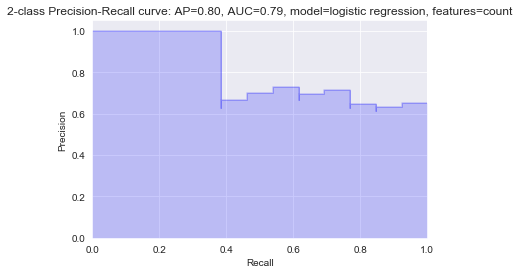

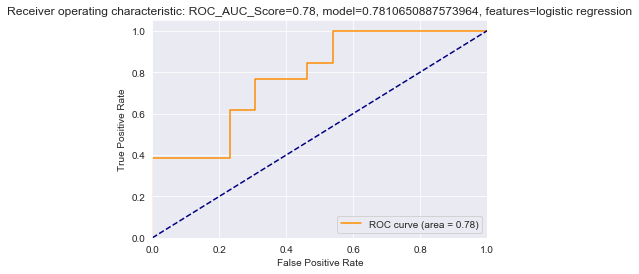

roc auc score: 0.7810650887573964


In [71]:
show_performance(yvalid, predictions, ypred, 'logistic regression', 'count')

It shows that the tf-idf feature achieves better performance compared to the count features.

- ### Dimensionality reduction using truncated SVD (Singular-Value Decomposition).

The Singular-Value Decomposition, or SVD for short, is a matrix decomposition method for reducing a matrix to its constituent parts 
in order to make certain subsequent matrix calculations simpler.

For the case of simplicity we will focus on the SVD for real-valued matrices and ignore the case for complex numbers.

$$A = U \cdot Sigma \cdot V^T$$

Where A is the real m x n matrix that we wish to decompose, U is an m x m matrix, Sigma (often represented by the uppercase Greek letter Sigma) is an m x n diagonal matrix, and V^T is the  transpose of an n x n matrix where T is a superscript.

The diagonal values in the Sigma matrix are known as the singular values of the original matrix A. The columns of the U matrix are called the left-singular vectors of A, and the columns of V are called the right-singular vectors of A.

**SVD for Dimensionality Reduction**

A popular application of SVD is for dimensionality reduction.

Data with a large number of features, such as more features (columns) than observations (rows) may be reduced to a smaller subset of features that are most relevant to the prediction problem.

The result is a matrix with a lower rank that is said to approximate the original matrix.

To do this we can perform an SVD operation on the original data and select the top k largest singular values in Sigma. These columns can be selected from Sigma and the rows selected from V^T.

An approximate B of the original vector A can then be reconstructed.

$$B = U \cdot Sigmak \cdot V^T$$

In natural language processing, this approach can be used on matrices of word occurrences or word frequencies in documents and is called Latent Semantic Analysis or Latent Semantic Indexing.

In practice, we can retain and work with a descriptive subset of the data called T. This is a dense summary of the matrix or a projection.

$$T = U \cdot Sigmak $$

Further, this transform can be calculated and applied to the original matrix A as well as other similar matrices.

$$T = U \cdot Sigmak $$

The scikit-learn provides a TruncatedSVD class that implements this capability directly.

The TruncatedSVD class can be created in which you must specify the number of desirable features or components to select, e.g. 2. Once created, you can fit the transform (e.g. calculate V^Tk) by calling the fit() function, then apply it to the original matrix by calling the transform() function. The result is the transform of A called T above.

**LSA (Latent Semantic Analysis)**

Latent Semantic Analysis is a technique for creating a vector representation of a document. 
Having a vector representation of a document gives you a way to compare documents for their similarity by calculating the distance between the vectors. This in turn means you can do handy things like classifying documents to determine which of a set of known topics they most likely belong to.

Classification implies you have some known topics that you want to group documents into, and that you have some labelled training data. 

- tf-idf

The first step in LSA is actually a separate algorithm that you may already be familiar with. It’s called term frequency-inverse document frequency, or tf-idf for short.

- LSA

LSA takes tf-idf one step further. 
We just use SVD to perform dimensionality reduction on the tf-idf vectors.



**Reference**

https://machinelearningmastery.com/singular-value-decomposition-for-machine-learning/

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

https://towardsdatascience.com/latent-semantic-analysis-sentiment-classification-with-python-5f657346f6a3

http://mccormickml.com/2016/03/25/lsa-for-text-classification-tutorial/

In [72]:
svd = decomposition.TruncatedSVD(n_components=100)
svd.fit(xtrain_tfv)
xtrain_svd = svd.transform(xtrain_tfv)
xvalid_svd = svd.transform(xvalid_tfv)

In [73]:
xtrain_tfv.shape

(101, 633)

In [74]:
xtrain_svd.shape

(101, 100)

In [75]:
# Fitting a simple Logistic Regression on TFIDF
clf = LogisticRegression()
clf.fit(xtrain_svd, ytrain)

predictions = clf.predict_proba(xvalid_svd)
ypred = clf.predict(xvalid_svd)

logloss: 0.611 
pr-auc: 0.8626614134324302
average precision: 0.8677735134331941
              precision    recall  f1-score   support

           0       0.75      0.69      0.72        13
           1       0.71      0.77      0.74        13

   micro avg       0.73      0.73      0.73        26
   macro avg       0.73      0.73      0.73        26
weighted avg       0.73      0.73      0.73        26



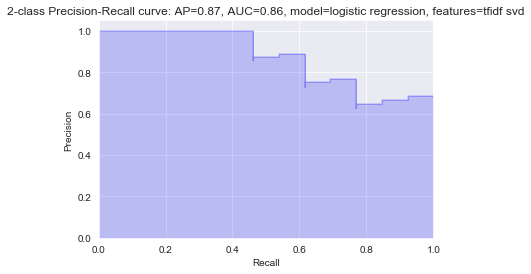

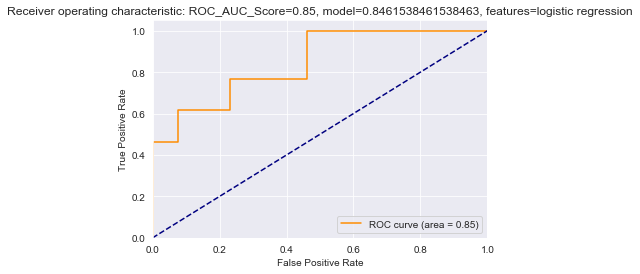

roc auc score: 0.8461538461538463


In [76]:
show_performance(yvalid, predictions, ypred, 'logistic regression', 'tfidf svd')

In [77]:
show_error_classification(yvalid, ypred)

index: 0
Booked Lufthansa flight Cologne-Berlin on 28 Jan. On 2 Jan I got the information that the flight was operated by Germanwings a German low-cost carrier. So was the flight. Low cost: 1 hrs delayed for my beer I had to pay in Euros - cash. Lounge use was denied as the flight was operated under 4U code. No service for a high Lufthansa price. Not recommended very disappointed.
true label: 0


index: 1
First time I have used Germanwings for connecting flights (via Hamburg). The APP does not work properly. They are unable to issue both boarding cards on check in causing unnecessary inconvenience. Their Live Twitter response averages 24 hours to reply. Cabin crew spend most time behind front galley curtains. Also fail to do proper cabin secure checks prior to landing. Seats new ultra thin models OK for short flights. Seat pitch OK on the extra space seats. Smart fare snack boring and repetitive. They have taken over a lot of Lufthansa routes and to be honest they are not really geared

It shows that dimensionality reduction using truncated SVD does not improve the performance.

- ### Naive Bayes

In [78]:
# Fitting a simple Naive Bayes on TFIDF
clf = MultinomialNB()
clf.fit(xtrain_tfv, ytrain)

predictions = clf.predict_proba(xvalid_tfv)
ypred = clf.predict(xvalid_tfv)

logloss: 0.556 
pr-auc: 0.8857951173353649
average precision: 0.8900704472685896
              precision    recall  f1-score   support

           0       0.73      0.62      0.67        13
           1       0.67      0.77      0.71        13

   micro avg       0.69      0.69      0.69        26
   macro avg       0.70      0.69      0.69        26
weighted avg       0.70      0.69      0.69        26



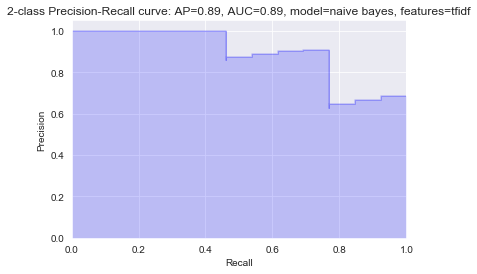

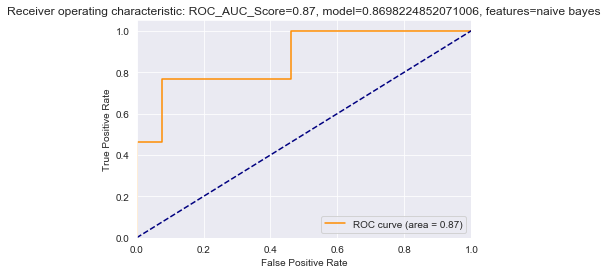

roc auc score: 0.8698224852071006


In [79]:
show_performance(yvalid, predictions, ypred, 'naive bayes', 'tfidf')

It shows that compared to logistic regression, naive bayes classifier achieves better performance.

In [80]:
show_error_classification(yvalid, ypred)

index: 0
Booked Lufthansa flight Cologne-Berlin on 28 Jan. On 2 Jan I got the information that the flight was operated by Germanwings a German low-cost carrier. So was the flight. Low cost: 1 hrs delayed for my beer I had to pay in Euros - cash. Lounge use was denied as the flight was operated under 4U code. No service for a high Lufthansa price. Not recommended very disappointed.
true label: 0


index: 1
First time I have used Germanwings for connecting flights (via Hamburg). The APP does not work properly. They are unable to issue both boarding cards on check in causing unnecessary inconvenience. Their Live Twitter response averages 24 hours to reply. Cabin crew spend most time behind front galley curtains. Also fail to do proper cabin secure checks prior to landing. Seats new ultra thin models OK for short flights. Seat pitch OK on the extra space seats. Smart fare snack boring and repetitive. They have taken over a lot of Lufthansa routes and to be honest they are not really geared

It shows that logistic regression achieves better performance compared to naive bayes.

- ### XGBoost


**Reference**

https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/

In [81]:
# Fitting a simple xgboost on tf-idf
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1, n_jobs=4)

clf.fit(xtrain_tfv.tocsc(), ytrain)

predictions = clf.predict_proba(xvalid_tfv.tocsc())
ypred = clf.predict(xvalid_tfv.tocsc())


logloss: 0.546 
pr-auc: 0.8367906665983587
average precision: 0.8430985680985679
              precision    recall  f1-score   support

           0       0.71      0.77      0.74        13
           1       0.75      0.69      0.72        13

   micro avg       0.73      0.73      0.73        26
   macro avg       0.73      0.73      0.73        26
weighted avg       0.73      0.73      0.73        26



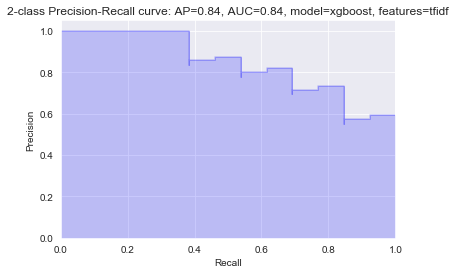

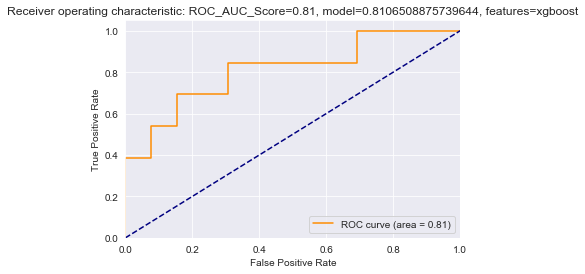

roc auc score: 0.8106508875739644


In [82]:
show_performance(yvalid, predictions, ypred, 'xgboost', 'tfidf')

In [83]:
show_error_classification(yvalid, ypred)

index: 0
4U7779 and 4U7778 May16 and May 26 PRG-HAM-PRG economy class. A decent low cost option for short flights within Europe. If you want to get from A to B in a cost efficient manner it's an alternative. Flights would've left on time if it wouldn't have taken the flight attendants almost 10 minutes to get a passenger to finally stop talking on his cell phone thus delaying the safety instructions. The in-flight magazine is the worst I've ever seen. It's full of advertisements. Although I didn't order anything the prices for beverages and snacks seem to be the same as on other low cost carriers.
true label: 1


index: 1
Went with Germanwings from Manchester to Cologne 21st October returned 28th October first time with this airline very satisfied and would definitely recommend to friends flights on time and staff very helpful.
true label: 1


index: 2
Fly an average of twice a year between North Rhine-Westphalia and Zürich. This time I flew Germanwings from CGN. Service is at the same

It shows xgboost achievs comparable performance compared to logistic regression.

- #### Hyperparameter tuning


In [84]:
xgb_clf = xgb.XGBClassifier()

param_dist = {'learning_rate': [0.01, 0.05, 0.07], 
              'max_depth': [4, 6, 8],
              'n_estimators': [100, 200, 400],
              #'min_child_weight': [2, 4],
              #'silent': [1],
              #'subsample': [0.7],
              #'colsample_bytree': [0.7],
              #'nthread':[4], #when use hyperthread, xgboost may become slower
             }

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
# mll_scorer = metrics.make_scorer(multiclass_logloss, greater_is_better=False, needs_proba=True)
search = RandomizedSearchCV(estimator = xgb_clf, 
                            param_distributions = param_dist, 
                            n_jobs = 4,
                            verbose = 1,
                            cv = 3,
                            n_iter=10,
                            #scoring=mll_scorer,
                           )

search.fit(xtrain_tfv.tocsc(), ytrain)

print('xgboost (hyperparameter tuning with grid search)')
print(search.best_score_)
print(search.best_params_)

predictions = search.predict_proba(xvalid_tfv.tocsc())
ypred = search.predict(xvalid_tfv.tocsc())


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


xgboost (hyperparameter tuning with grid search)
0.7524752475247525
{'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.07}


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.8s finished


logloss: 0.549 
pr-auc: 0.7783903568316524
average precision: 0.7915281299896684
              precision    recall  f1-score   support

           0       0.71      0.77      0.74        13
           1       0.75      0.69      0.72        13

   micro avg       0.73      0.73      0.73        26
   macro avg       0.73      0.73      0.73        26
weighted avg       0.73      0.73      0.73        26



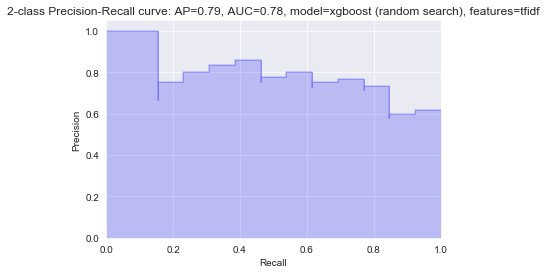

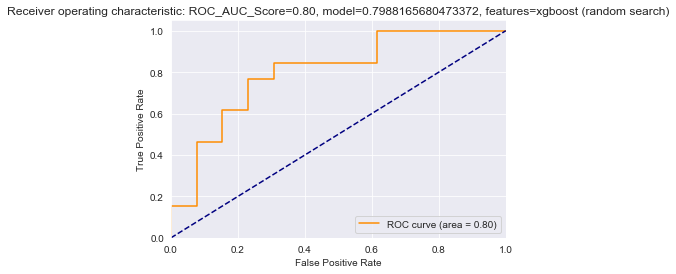

roc auc score: 0.7988165680473372


In [85]:
show_performance(yvalid, predictions, ypred, 'xgboost (random search)', 'tfidf')

In [86]:
show_error_classification(yvalid, ypred)

index: 0
4U7779 and 4U7778 May16 and May 26 PRG-HAM-PRG economy class. A decent low cost option for short flights within Europe. If you want to get from A to B in a cost efficient manner it's an alternative. Flights would've left on time if it wouldn't have taken the flight attendants almost 10 minutes to get a passenger to finally stop talking on his cell phone thus delaying the safety instructions. The in-flight magazine is the worst I've ever seen. It's full of advertisements. Although I didn't order anything the prices for beverages and snacks seem to be the same as on other low cost carriers.
true label: 1


index: 1
First time I have used Germanwings for connecting flights (via Hamburg). The APP does not work properly. They are unable to issue both boarding cards on check in causing unnecessary inconvenience. Their Live Twitter response averages 24 hours to reply. Cabin crew spend most time behind front galley curtains. Also fail to do proper cabin secure checks prior to landing.

- #### Summary

Hyperparameter tuning with random search does not improve the performance.

- ### Word Embeddings 

Download the GloVe vectors from here 
http://www-nlp.stanford.edu/data/glove.840B.300d.zip


**Reference**

- Word embedding


https://machinelearningmastery.com/what-are-word-embeddings/


https://www.youtube.com/watch?v=5PL0TmQhItY


https://www.coursera.org/learn/nlp-sequence-models/home/week/2


- Glove embedding

https://www.kaggle.com/stacykurnikova/using-glove-embedding

https://www.quora.com/How-is-GloVe-different-from-word2vec


- Fast word embedding

https://www.kaggle.com/vsmolyakov/keras-cnn-with-fasttext-embeddings

https://spenai.org/bravepineapple/faster_em/


- NLP

https://www.kaggle.com/CVxTz/keras-bidirectional-lstm-baseline-lb-0-069

https://www.kaggle.com/jhoward/improved-lstm-baseline-glove-dropout

In [87]:
# load the GloVe vectors in a dictionary
embeddings_index = {}
f = open('glove.6B.50d.txt')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

400000it [00:06, 57662.97it/s]

Found 400000 word vectors.


In [88]:
# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    #stop_words = nltk.download('stopwords')
    #words = str(s).lower().decode('utf-8')
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [89]:
# create sentence vectors using the above function for training and validation set
xtrain_glove = [sent2vec(x) for x in tqdm(xtrain)]
xvalid_glove = [sent2vec(x) for x in tqdm(xvalid)]

100%|██████████| 26/26 [00:00<00:00, 801.88it/s]


In [90]:
xtrain_glove = np.array(xtrain_glove)
xvalid_glove = np.array(xvalid_glove)

In [91]:
# Fitting a simple xgboost on glove features
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1, n_jobs=4)

clf.fit(xtrain_glove, ytrain)

predictions = clf.predict_proba(xvalid_glove)
ypred = clf.predict(xvalid_glove)

logloss: 0.918 
pr-auc: 0.5535590182157817
average precision: 0.5892845627157368
              precision    recall  f1-score   support

           0       0.64      0.69      0.67        13
           1       0.67      0.62      0.64        13

   micro avg       0.65      0.65      0.65        26
   macro avg       0.65      0.65      0.65        26
weighted avg       0.65      0.65      0.65        26



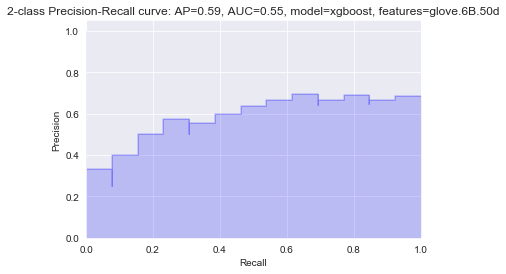

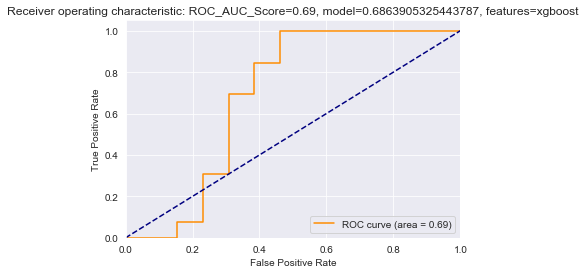

roc auc score: 0.6863905325443787


In [92]:
show_performance(yvalid, predictions, ypred, 'xgboost', 'glove.6B.50d')

It shows that using xgboost with glove embedding features does not improve the performance.

- ### Deep Learning

In [93]:
# scale the data before any neural net:
scl = preprocessing.StandardScaler()
xtrain_glove_scl = scl.fit_transform(xtrain_glove)
xvalid_glove_scl = scl.transform(xvalid_glove)

In [94]:
xtrain_glove.shape

(101, 50)

In [95]:
# we need to binarize the labels for the neural net
ytrain_enc = np_utils.to_categorical(ytrain)
yvalid_enc = np_utils.to_categorical(yvalid)

In [96]:
ytrain_enc.shape

(101, 2)

In [97]:
yvalid_enc.shape

(26, 2)

In [98]:
xtrain_glove.shape[1]

50

In [99]:
# create a simple 2 layers sequential neural net
model = Sequential()

model.add(Dense(100, input_dim=xtrain_glove.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(2))
model.add(Activation('softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [100]:
model.fit(xtrain_glove_scl, y=ytrain_enc, 
          batch_size=512, 
          epochs=10, 
          verbose=1, 
          #validation_data=(xvalid_glove_scl, yvalid_enc)
         )

Epoch 1/10
101/101 [==============================] - 1s 7ms/step - loss: 1.1655
Epoch 2/10
101/101 [==============================] - 0s 52us/step - loss: 0.9071
Epoch 3/10
101/101 [==============================] - 0s 46us/step - loss: 0.9009
Epoch 4/10
101/101 [==============================] - 0s 57us/step - loss: 0.8108
Epoch 5/10
101/101 [==============================] - 0s 42us/step - loss: 0.5746
Epoch 6/10
101/101 [==============================] - 0s 49us/step - loss: 0.5471
Epoch 7/10
101/101 [==============================] - 0s 61us/step - loss: 0.6023
Epoch 8/10
101/101 [==============================] - 0s 47us/step - loss: 0.4304
Epoch 9/10
101/101 [==============================] - 0s 49us/step - loss: 0.4208
Epoch 10/10
101/101 [==============================] - 0s 46us/step - loss: 0.4197


In [101]:
predictions = model.predict(xvalid_glove_scl)

ypred = predictions.argmax(axis=-1)

logloss: 0.853 
pr-auc: 0.5845864103217044
average precision: 0.6196901954254895
              precision    recall  f1-score   support

           0       0.67      0.77      0.71        13
           1       0.73      0.62      0.67        13

   micro avg       0.69      0.69      0.69        26
   macro avg       0.70      0.69      0.69        26
weighted avg       0.70      0.69      0.69        26



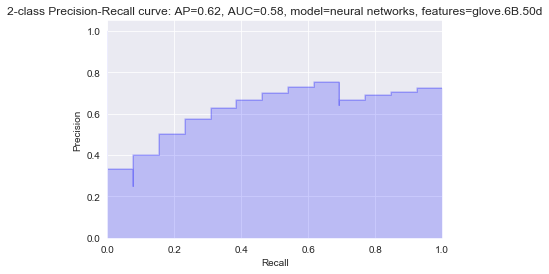

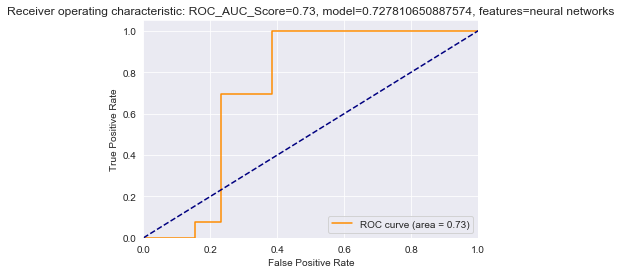

roc auc score: 0.727810650887574


In [102]:
show_performance(yvalid, predictions, ypred, 'neural networks', 'glove.6B.50d')

- #### LSTM

https://www.coursera.org/learn/nlp-sequence-models/lecture/KXoay/long-short-term-memory-lstm

In [103]:
# using keras tokenizer here
token = keras.preprocessing.text.Tokenizer(num_words=None)
max_len = 70

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

# zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

In [104]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, xtrain_glove.shape[1]))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 2152/2152 [00:00<00:00, 359736.25it/s]


In [105]:
embedding_matrix.shape

(2153, 50)

In [106]:
# LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     embedding_matrix.shape[1],
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(5, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')


In [107]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, 
          batch_size=1024, 
          epochs=10, 
          verbose=0, 
          callbacks=[earlystop],
          #validation_data=(xvalid_pad, yvalid_enc)
         )

In [108]:
predictions = model.predict(xvalid_pad)

ypred = predictions.argmax(axis=-1)

logloss: 0.693 
pr-auc: 0.5019446817435727
average precision: 0.5255833015778448
              precision    recall  f1-score   support

           0       0.50      0.92      0.65        13
           1       0.50      0.08      0.13        13

   micro avg       0.50      0.50      0.50        26
   macro avg       0.50      0.50      0.39        26
weighted avg       0.50      0.50      0.39        26



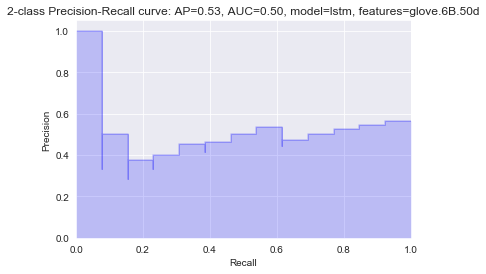

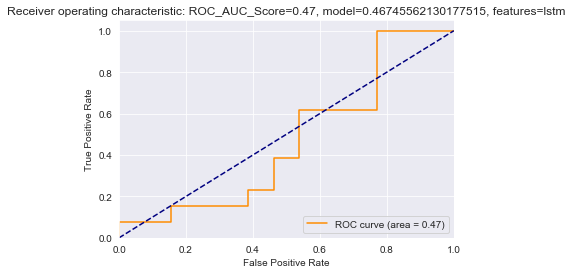

roc auc score: 0.46745562130177515


In [109]:
show_performance(yvalid, predictions, ypred, 'lstm', 'glove.6B.50d')

In [110]:
show_error_classification(yvalid, ypred)

index: 0
4U7779 and 4U7778 May16 and May 26 PRG-HAM-PRG economy class. A decent low cost option for short flights within Europe. If you want to get from A to B in a cost efficient manner it's an alternative. Flights would've left on time if it wouldn't have taken the flight attendants almost 10 minutes to get a passenger to finally stop talking on his cell phone thus delaying the safety instructions. The in-flight magazine is the worst I've ever seen. It's full of advertisements. Although I didn't order anything the prices for beverages and snacks seem to be the same as on other low cost carriers.
true label: 1


index: 1
Easy Check-In at Düsseldorf. The Germanwings flight was on time. Seats good for a low-cost airline. The food was terrible and expensive. The normal Ticket price excludes luggage, and for including luggage check-in you have to pay extra money. Staff were friendly.
true label: 1


index: 2
Went with Germanwings from Manchester to Cologne 21st October returned 28th Octob

- #### GRU

https://www.coursera.org/learn/nlp-sequence-models/lecture/agZiL/gated-recurrent-unit-gru

In [111]:
# GRU with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     embedding_matrix.shape[1],
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(5, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [112]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, 
          batch_size=1024, 
          epochs=100, 
          verbose=0, 
          callbacks=[earlystop],
          #validation_data=(xvalid_pad, yvalid_enc), 
         )

In [113]:
predictions = model.predict(xvalid_pad)

ypred = predictions.argmax(axis=-1)

logloss: 0.715 
pr-auc: 0.5123351617577986
average precision: 0.5551962657225814
              precision    recall  f1-score   support

           0       0.53      0.69      0.60        13
           1       0.56      0.38      0.45        13

   micro avg       0.54      0.54      0.54        26
   macro avg       0.54      0.54      0.53        26
weighted avg       0.54      0.54      0.53        26



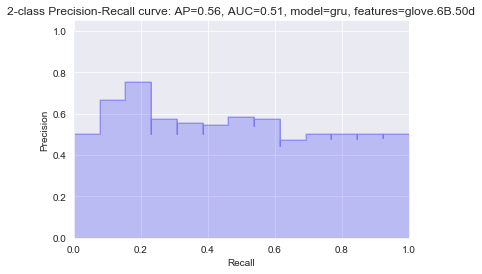

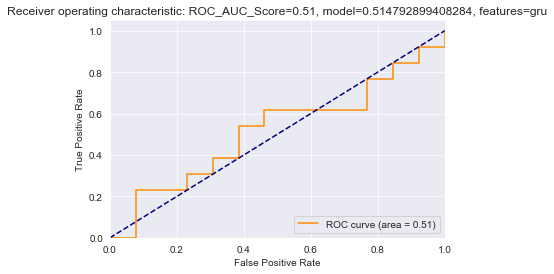

roc auc score: 0.514792899408284


In [114]:
show_performance(yvalid, predictions, ypred, 'gru', 'glove.6B.50d')

- #### Bi-directional LSTM

https://www.coursera.org/learn/nlp-sequence-models/lecture/fyXnn/bidirectional-rnn

In [115]:
# A simple bidirectional LSTM with glove embeddings and two dense layers
model = Sequential()

model.add(Embedding(len(word_index) + 1,
                     embedding_matrix.shape[1],
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))

model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(5, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, 
          epochs=200, 
          verbose=0, 
          callbacks=[earlystop]
          #validation_data=(xvalid_pad, yvalid_enc), 
         )

In [116]:
predictions = model.predict(xvalid_pad)

ypred = predictions.argmax(axis=-1)

logloss: 0.548 
pr-auc: 0.7752251518357838
average precision: 0.7866363398576037
              precision    recall  f1-score   support

           0       0.71      0.77      0.74        13
           1       0.75      0.69      0.72        13

   micro avg       0.73      0.73      0.73        26
   macro avg       0.73      0.73      0.73        26
weighted avg       0.73      0.73      0.73        26



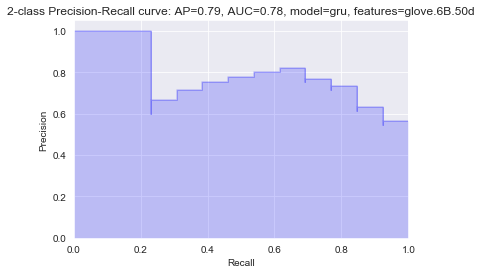

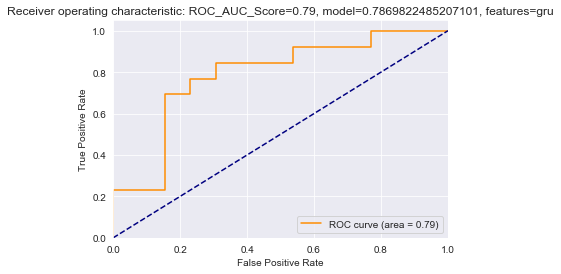

roc auc score: 0.7869822485207101


In [117]:
show_performance(yvalid, predictions, ypred, 'gru', 'glove.6B.50d')

In [118]:
show_error_classification(yvalid, ypred)

index: 0
4U7779 and 4U7778 May16 and May 26 PRG-HAM-PRG economy class. A decent low cost option for short flights within Europe. If you want to get from A to B in a cost efficient manner it's an alternative. Flights would've left on time if it wouldn't have taken the flight attendants almost 10 minutes to get a passenger to finally stop talking on his cell phone thus delaying the safety instructions. The in-flight magazine is the worst I've ever seen. It's full of advertisements. Although I didn't order anything the prices for beverages and snacks seem to be the same as on other low cost carriers.
true label: 1


index: 1
Found the customer service centre staff awful. They failed to mention that there is an EUR 80 fee when using the call centre. When I called back to query this I was told to 'take it or leave it' and hung up on. When I complained they denied everything and closed the complaint. To date I have not heard from them again. From previous experience the airline itself is gre

The above experiments show that with out a large amount training data, deep learning can't achieve good performance.

- #### Summary

    - With the small amount of text data, Bi-directional LSTM with GloVe achieves comparable results.


## Future work

- **Topic modeling**
    - Have a deeper understanding about LDA

- **Knowledge Graph**


- **Getting more data**
    - Get review data from other flight companies
    - Generate text data with neural networks

- **Sentiment analysis with deep learning**
    - Try different neural network architectures, e.g., BERT (https://medium.com/huggingface/multi-label-text-classification-using-bert-the-mighty-transformer-69714fa3fb3d)
    
- **Word embedding**
    - Try other word embedding algorithms, e.g., fastText (https://fasttext.cc/)

- **Ensembling**
    - https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle

## More Topic Modeling

The following code is adapted from 

https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

In [119]:
# python3 -m spacy download en

import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV

from pprint import pprint

import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

- ### Clean up the text

In [120]:
# Convert to list
data = df_review['Review'].values.tolist()

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['We flew with Germanwings (or tried to) on September 30th. After two lengthy '
 'delays passengers were notified that the flight was cancelled and to return '
 'to the check-in counter for further information. After waiting at the '
 'counter for another 30 minutes or so, staff began issuing refunds or '
 'providing alternate travel options to passengers. By this point it was quite '
 'late in the evening with limited options (plus we were 5+ hours after '
 'planned departure). We managed to get a voucher with 3 other passenger to '
 'get a flight from Stuttgart to Zurich with an ongoing connection to '
 'Amsterdam (flights were with Swiss). We made the flight and the connector '
 '(which was held back waiting for about 70 of us) however luggage did not '
 'make it. Short of this is the airline was ill-prepared to manage this. They '
 'offered little information or options to passengers. since returning home I '
 'have been attempting to contact them via email and phone calls to discu

<>:5: DeprecationWarning:

invalid escape sequence \s

<>:5: DeprecationWarning:

invalid escape sequence \s

<>:5: DeprecationWarning:

invalid escape sequence \s

<ipython-input-120-10e8e12f786f>:5: DeprecationWarning:

invalid escape sequence \s



- ### Tokenize

Tokenize and Clean-up using gensim’s simple_preprocess().

Tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

In [121]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['we', 'flew', 'with', 'germanwings', 'or', 'tried', 'to', 'on', 'september', 'th', 'after', 'two', 'lengthy', 'delays', 'passengers', 'were', 'notified', 'that', 'the', 'flight', 'was', 'cancelled', 'and', 'to', 'return', 'to', 'the', 'check', 'in', 'counter', 'for', 'further', 'information', 'after', 'waiting', 'at', 'the', 'counter', 'for', 'another', 'minutes', 'or', 'so', 'staff', 'began', 'issuing', 'refunds', 'or', 'providing', 'alternate', 'travel', 'options', 'to', 'passengers', 'by', 'this', 'point', 'it', 'was', 'quite', 'late', 'in', 'the', 'evening', 'with', 'limited', 'options', 'plus', 'we', 'were', 'hours', 'after', 'planned', 'departure', 'we', 'managed', 'to', 'get', 'voucher', 'with', 'other', 'passenger', 'to', 'get', 'flight', 'from', 'stuttgart', 'to', 'zurich', 'with', 'an', 'ongoing', 'connection', 'to', 'amsterdam', 'flights', 'were', 'with', 'swiss', 'we', 'made', 'the', 'flight', 'and', 'the', 'connector', 'which', 'was', 'held', 'back', 'waiting', 'for', 'a

- ### Lemmatization

Lemmatization is a process where we convert words to its root word.

For example: ‘Studying’ becomes ‘Study’, ‘Meeting becomes ‘Meet’, ‘Better’ and ‘Best’ becomes ‘Good’.

The advantage of this is, we get to reduce the total number of unique words in the dictionary. 

As a result, the number of columns in the document-word matrix (created by CountVectorizer in the next step) will be denser with lesser columns.

You can expect better topics to be generated in the end.

In [122]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' 
                                   for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en', 
                 disable=['parser', 'ner']
                )

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['fly germanwing try september lengthy delay passenger be notify flight be cancel return check counter further information wait counter minute so staff begin issue refund provide alternate travel option passenger point be quite late evening limited option be hour plan departure manage get vouch other passenger get flight stuttgart zurich ongoing connection amsterdam flight be swiss make flight connector which be hold wait however luggage do not make short be airline be ill prepared manage offer little information option passenger return home have be attempt contact email phone call discuss compensation passenger right brochure have be unresponsive not good way run business', 'be less impressed germanwing service say least  first connection hamburg stewardess have tell could have water free everything have be charge  second connection hamburg london be refuse water be pregnant not feel well find disgust fact passenger will not be offer water be unwell will not be look way needless say s

- ### Create the Document-Word matrix

The LDA topic model algorithm requires a document word matrix as the main input.

The below code configured the CountVectorizer to consider words that has occurred at least 10 times (min_df), 
remove built-in english stopwords, convert all words to lowercase, 
and a word can contain numbers and alphabets of at least length 3 in order to be qualified as a word.


In [123]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

- ### Check the Sparsicity

Sparsicity is nothing but the percentage of non-zero datapoints in the document-word matrix, that is data_vectorized.


In [124]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  16.76571088991235 %


- ### Build LDA model with sklearn

In [125]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_topics=5,                # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=42,           # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = 4,                # Use 4 available CPUs
                                     )

lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=4, n_topics=5, perp_tol=0.1,
             random_state=42, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


- ### Diagnose model performance with perplexity and log-likelihood

A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good. Let’s check for our model.

In [126]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())


Log Likelihood:  -14002.570972577021
Perplexity:  104.79613950362412
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': 4,
 'n_topics': 5,
 'perp_tol': 0.1,
 'random_state': 42,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


- ### Use GridSearch to find the best LDA model

The most important tuning parameter for LDA models is n_components (number of topics). 

In addition, I am going to search learning_decay (which controls the learning rate) as well.

Besides these, other possible search params could be learning_offset (downweigh early iterations. Should be > 1) and max_iter. These could be worth experimenting if you have enough computing resources.


In [127]:
# Define Search Param
search_params = {'n_components': [2, 4, 6, 8, 10], 
                 'learning_decay': [.5, .7, .9]
                }

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_components': [2, 4, 6, 8, 10], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

- ### Show the best topic model and its parameters

In [128]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 2}
Best Log Likelihood Score:  -4783.64742645336
Model Perplexity:  89.13006940861969


The result shows that for LDA the best number of topics is 2. I believe the two topics would be positive review and negative review.

- ### Show the dominant topic in each document

In [129]:
# Create Document - Topic Matrix
#lda_output = lda_model.transform(data_vectorized)
lda_output = best_lda_model.transform(data_vectorized)

# column names
#topicnames = ["Topic" + str(i) for i in range(lda_model.n_topics)]
topicnames = ["Topic" + str(i) for i in range(2)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,dominant_topic
Doc0,0.98,0.02,0
Doc1,0.81,0.19,0
Doc2,0.92,0.08,0
Doc3,0.4,0.6,1
Doc4,0.98,0.02,0
Doc5,0.98,0.02,0
Doc6,0.03,0.97,1
Doc7,0.98,0.02,0
Doc8,0.96,0.04,0
Doc9,0.08,0.92,1


- ### Review topics distribution across documents

In [130]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,74
1,1,53


- ### Visualize the LDA model with pyLDAvis

The pyLDAvis offers the best visualization to view the topics-keywords distribution.

**TODO** : have a deep understanding of the visualization.

In [131]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=            x        y  topics  cluster   Freq
topic                                         
0     -60.312  141.370       1        1 60.519
1      60.313 -141.369       2        1 39.481, topic_info=    Category   Freq        Term   Total  loglift  logprob
48   Default 75.000        good  75.000   30.000   30.000
80   Default 39.000       price  39.000   29.000   29.000
26   Default 34.000        cost  34.000   28.000   28.000
65   Default 28.000         low  28.000   27.000   27.000
84   Default 53.000      return  53.000   26.000   26.000
87   Default 80.000        seat  80.000   25.000   25.000
8    Default 21.000      berlin  21.000   24.000   24.000
52   Default 43.000        hour  43.000   23.000   23.000
44   Default 31.000    friendly  31.000   22.000   22.000
33   Default 20.000   efficient  20.000   21.000   21.000
60   Default 22.000     legroom  22.000   20.000   20.000
66   Default 40.000   lufthansa  40.000   19.000   19.000
16   Default 15.000     carrier  15.000   18.000   18.000
91   Default 20.000       smart  20.000   17.000   17.000
95   Default 31.000        tell  31.000   16.000   16.000
17   Default 32.000         cgn  32.000   15.000   15.000
27   Default 48.000        crew  48.000   14.000   14.000
13   Default 13.000         buy  13.000   13.000   13.000
22   Default 19.000       clean  19.000   12.000   12.000
57   Default 36.000        late  36.000   11.000   11.000
68   Default 25.000        make  25.000   10.000   10.000
1    Default 43.000     airline  43.000    9.000    9.000
34   Default 18.000        euro  18.000    8.000    8.000
103  Default 21.000        wait  21.000    7.000    7.000
83   Default 10.000   recommend  10.000    6.000    6.000
63   Default 14.000        long  14.000    5.000    5.000
82   Default 16.000       quite  16.000    4.000    4.000
43   Default 21.000        free  21.000    3.000    3.000
102  Default 12.000       value  12.000    2.000    2.000
50   Default 15.000     hamburg  15.000    1.000    1.000
..       ...    ...         ...     ...      ...      ...
34    Topic2 14.140        euro  18.430    0.664   -4.431
98    Topic2 10.991      travel  14.548    0.649   -4.683
50    Topic2 11.625     hamburg  15.517    0.641   -4.627
66    Topic2 29.635   lufthansa  40.721    0.612   -3.691
17    Topic2 23.613         cgn  32.961    0.596   -3.918
46    Topic2 12.339      german  17.448    0.583   -4.568
72    Topic2 12.334         new  17.448    0.583   -4.568
12    Topic2  8.670     booking  12.599    0.556   -4.920
19    Topic2 11.536       cheap  17.439    0.516   -4.635
87    Topic2 50.685        seat  80.386    0.468   -3.155
1     Topic2 26.429     airline  43.571    0.429   -3.806
55    Topic2  9.276        just  15.491    0.417   -4.853
37    Topic2  9.597       extra  16.456    0.390   -4.819
85    Topic2  7.994       route  14.515    0.333   -5.002
42    Topic2 13.135        food  24.189    0.319   -4.505
67    Topic2 17.066     luggage  31.927    0.303   -4.243
47    Topic2 45.382  germanwing  99.563    0.144   -3.265
88    Topic2 24.918     service  52.211    0.190   -3.865
40    Topic2 70.198      flight 240.257   -0.301   -2.829
41    Topic2 23.911         fly  56.047    0.077   -3.906
77    Topic2 21.346         pay  47.362    0.132   -4.019
97    Topic2 27.784        time  78.210   -0.106   -3.756
93    Topic2 18.784       staff  42.525    0.112   -4.147
101   Topic2 15.225         use  29.983    0.252   -4.357
20    Topic2 21.020       check  67.556   -0.238   -4.035
74    Topic2 14.769       offer  31.901    0.159   -4.388
96    Topic2 14.314      ticket  32.858    0.098   -4.419
11    Topic2 13.287        book  27.076    0.217   -4.494
78    Topic2 13.682       plane  39.584   -0.133   -4.464
23    Topic2 13.669     cologne  52.087   -0.408   -4.465

[123 rows x 6 columns], token_table=      Topic  Freq       Term
term                        
1         1 0.390    airline
1         2 0.597    airline
4         1 0.909   

- ### Show the Topic’s keywords

The weights of each keyword in each topic is contained in lda_model.components_ as a 2d array. The names of the keywords itself can be obtained from vectorizer object using get_feature_names().

Let’s use this info to construct a weight matrix for all keywords in each topic.



In [132]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
print(df_topic_keywords.head())

        aircraft  airline  airport  arrival  arrive   bad    bag  baggage  \
Topic0     9.296   17.824   16.277   12.148  21.942 6.976 23.921    9.216   
Topic1     6.704   27.176   10.723    2.852   2.058 4.024  7.079    5.784   

        berlin  board  ...  ticket   time  travel   trip   try    use  value  \
Topic0   0.719 26.882  ...  19.281 52.431   3.698 13.243 8.638 15.344  2.455   
Topic1  21.281 13.118  ...  14.719 28.569  11.302  5.757 4.362 15.656 10.545   

         wait  water   way  
Topic0 21.442 11.354 9.282  
Topic1  0.558  2.646 3.718  

[2 rows x 106 columns]


- ### Get the top 15 keywords each topic

From the above output, I want to see the top 15 keywords that are representative of the topic.

The show_topics() defined below creates that.

In [133]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,flight,germanwing,return,time,passenger,check,delay,crew,hour,cologne,minute,late,fly,tell,seat
Topic 1,flight,good,seat,germanwing,price,cost,lufthansa,time,low,airline,friendly,service,fly,cgn,pay


- ### TODO: Cluster documents that share similar topics and plot

### Conclusion

- Exploratory Data Analysis
- Sentiment analysis 
- Topic modeling

- ### Reference

**EDA**

https://www.kaggle.com/theoviel/improve-your-score-with-some-text-preprocessing

https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial


**Evaluation**


https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

https://medium.com/30-days-of-machine-learning/day-5-entropy-relative-entropy-and-cross-entropy-8369d67cc180

https://machinelearningmastery.com/loss-and-loss-functions-for-training-deep-learning-neural-networks/

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

https://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/

https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/

https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/

https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234


**NLP**

https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/kernels

https://www.kaggle.com/c/spooky-author-identification/kernels

https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle

https://www.kaggle.com/theoviel/improve-your-score-with-some-text-preprocessing

https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline

https://www.kaggle.com/tunguz/logistic-regression-with-words-and-char-n-grams

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

https://towardsdatascience.com/hacking-scikit-learns-vectorizers-9ef26a7170af

https://medium.com/usf-msds/choosing-the-right-metric-for-evaluating-machine-learning-models-part-2-86d5649a5428

https://medium.com/usf-msds/choosing-the-right-metric-for-machine-learning-models-part-1-a99d7d7414e4


**Latent Semantic Analysis (LSA)**

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

https://towardsdatascience.com/latent-semantic-analysis-sentiment-classification-with-python-5f657346f6a3

http://mccormickml.com/2016/03/25/lsa-for-text-classification-tutorial/


**General Data Science**

https://www.kaggle.com/kernels?sortBy=voteCount&group=everyone&pageSize=20